# 2022-09-01 • 1144 weights

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

In [5]:
d = 1
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1 / d,
    g_EI = 1 / d,
    g_IE = 4 / d,
    g_II = 4 / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment_simdata(s, p);

## Plot firing rates

In [24]:
using PyPlot

In [25]:
using VoltoMapSim.Plot

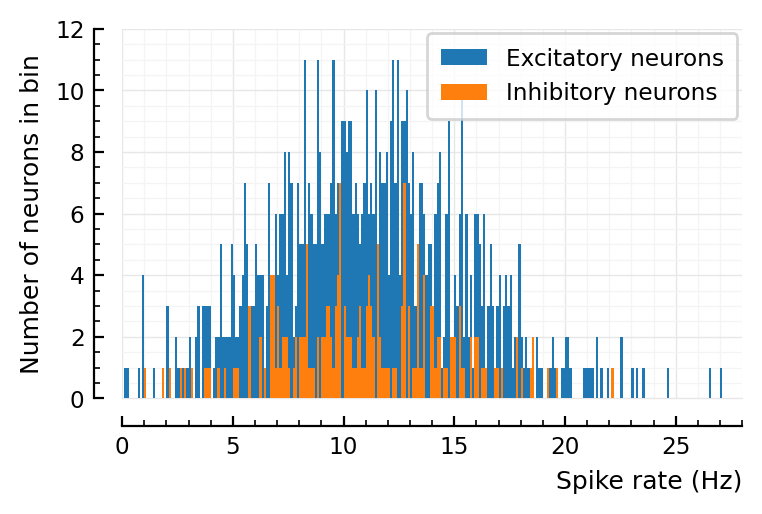

In [35]:
histplot_fr(s.spike_rates);

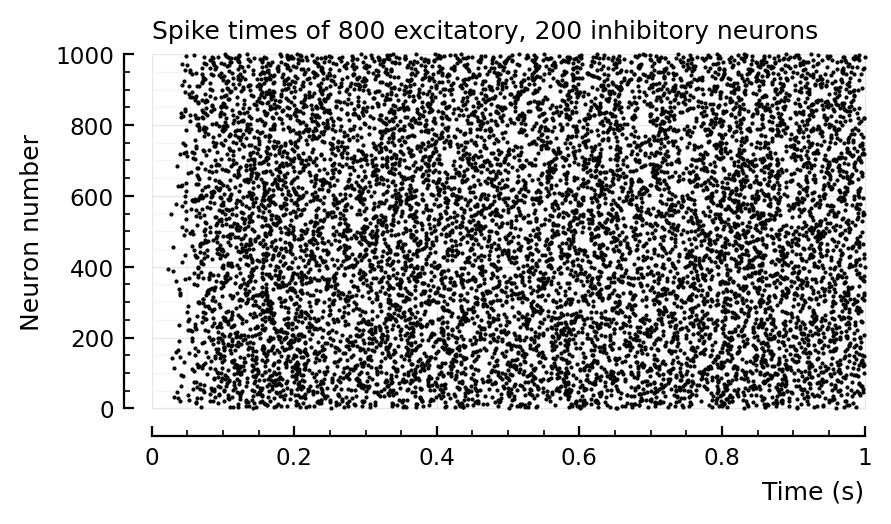

In [36]:
rasterplot(s.spike_times, tlim=[0,1]);

## Connection tests

(Using the new connection test and performance evaluation where we also predict exc or inh).
-- though results for unconnected are unchanged, so we can still compare with previous mass-eval (`2022-07-23__Record_many`).

In [12]:
using Base.Threads

In [22]:
detrates = Dict()
neurons = p.sim.network.record_v
pbar = Progress(length(neurons))
@threads for m in neurons
    perf = cached_conntest_eval(s, m, p, verbose = false)
    detrates[m] = perf.detection_rates
    next!(pbar)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Plot perf

In [26]:
exc_post = [1:40;]
inh_post = [801:810;];

In [33]:
function detplot(ids, groupname)
    N = length(ids)
    ax = ydistplot(
        "Exc. inputs" => [detrates[n].TPR_exc for n in ids],
        "Inh. inputs" => [detrates[n].TPR_inh for n in ids],
        "Unconn." => [detrates[n].FPR for n in ids],
        ylim = [0,1],
        hylabel = "Detection rates for $(groupname) neurons (n = $N)",
        ref = p.evaluation.α,
    )
    return nothing
end;

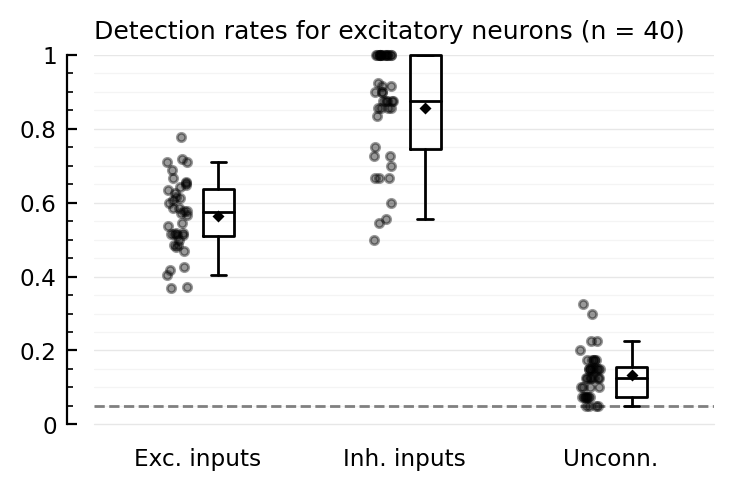

In [35]:
detplot(exc_post, "excitatory")

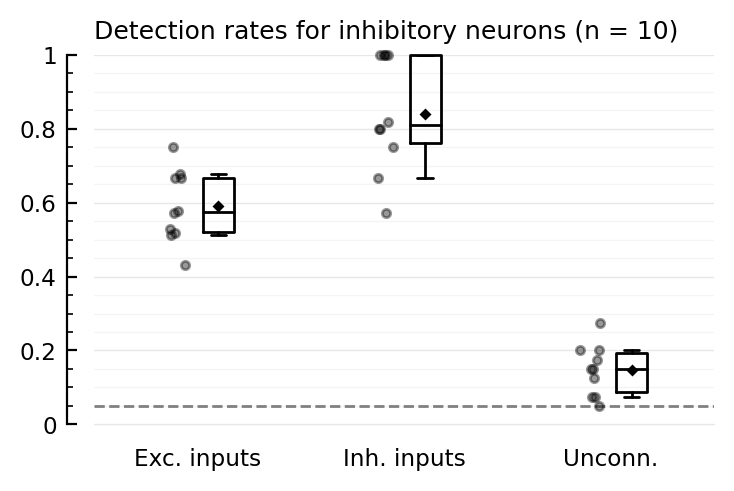

In [36]:
detplot(inh_post, "inhibitory")

Interesting!
1. Higher-than-α FPR exists here too
2. E→E is detected here!

(compare with `2022-07-23 • Record many neurons`, where E→E is not detected at all).

In `2022-05-13 • Network`, we had (only for 1 neuron instead of 40) low E→E detectability, no I→E detectability, and lower than α FPR.
But that net had the mistaken '1414' connection strength params (inh _inputs_ 4x as strong, instead of outputs).

## Inspect performance

In [40]:
m = 1
perf = cached_conntest_eval(s,m,p)
ENV["LINES"] = 100  # display all rows of table
perf.tested_neurons

,input_neuron_ID,real_type,predicted_type,pval,area_over_start
,Int64,Symbol,Symbol,Float64,Float64
1,139,exc,exc,0.01,17
2,681,exc,inh,0.01,-4
3,11,exc,exc,0.01,18
4,766,exc,exc,0.01,52
5,132,exc,exc,0.03,18.5
6,516,exc,exc,0.01,30.4
7,418,exc,inh,0.01,-3.7
8,565,exc,unconn,0.05,18.7
9,597,exc,exc,0.01,26.3


### Inhibitory input misclassified

one inh misclassified:

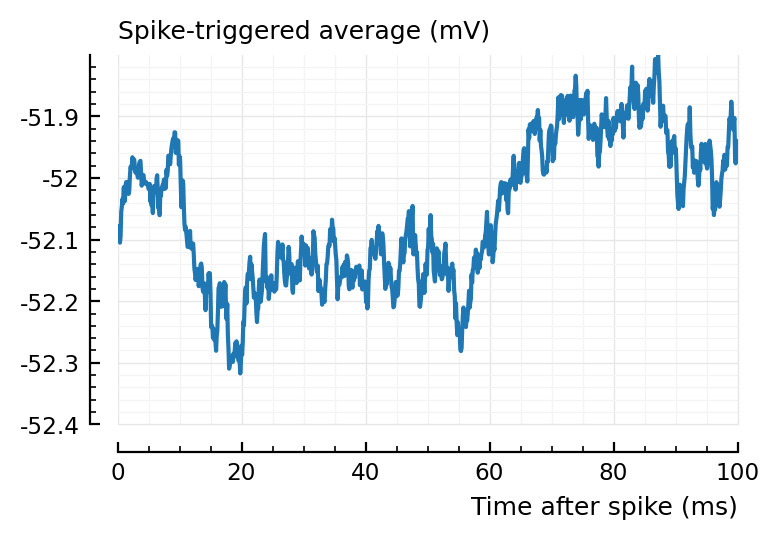

In [70]:
Plot.plotSTA(from::Int, to::Int, s, p, kw...) = plotSTA(s.signals[to].v, s.spike_times[from], p, kw...)
plotSTA(831, 1, s, p);

Not so clear. A clearer one:

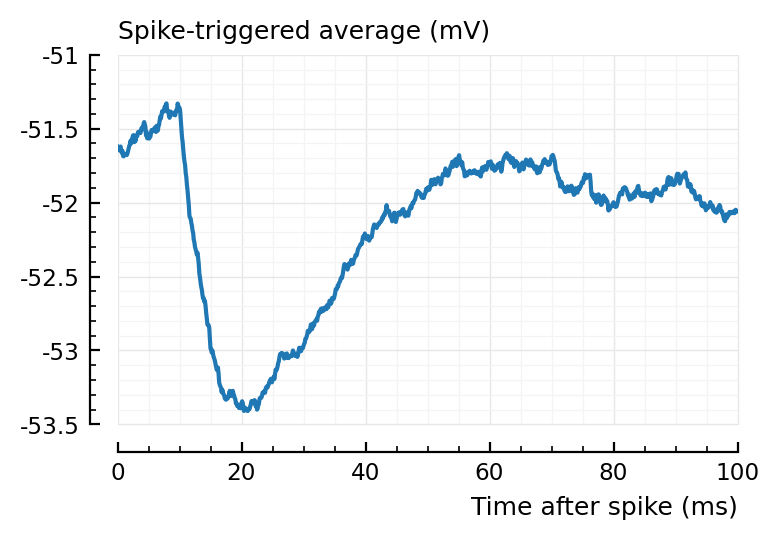

In [48]:
plotSTA(894, 1, s,p);

But yeah, it would be fixed with a shorter STA window.

### Exc input misclassified

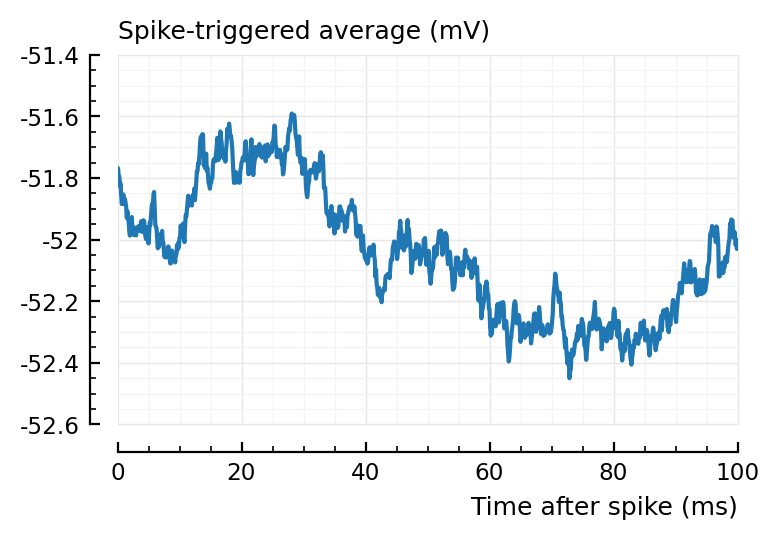

In [50]:
plotSTA(145, 1, s,p);

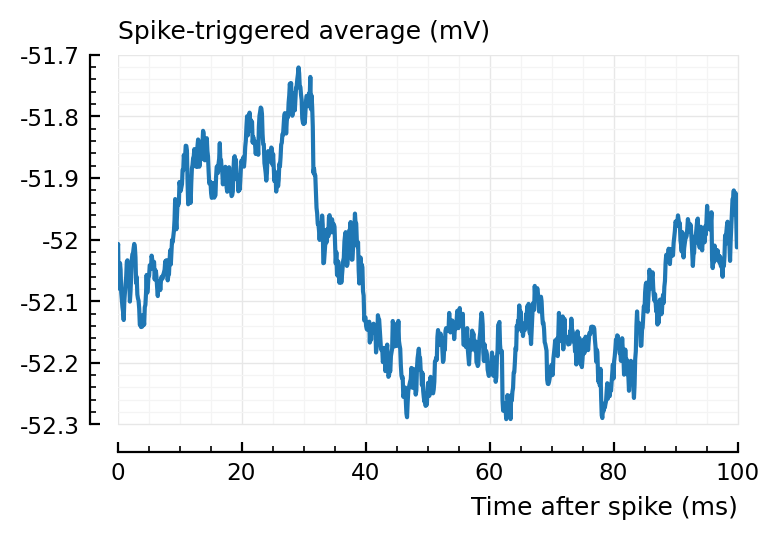

In [51]:
plotSTA(681, 1, s,p);

And again, shorter window would mitigate.

## Average STA window

```
For every recorded (exc) neuron..
    for all it's (exc) inputs..
        calc STA, and grand average all those
```

In [53]:
calcSTA(from::Int, to::Int, s, p) = calc_STA(s.signals[to].v, s.spike_times[from], p);

In [89]:
function calcMeanSTA(post; pre)
    avgSTA = nothing
    N = 0
    @showprogress for n in post
        ii = s.input_info[n]
        inputs = (pre == :exc) ? ii.exc_inputs : ii.inh_inputs
        for m in inputs
            STA = calcSTA(m, n, s, p)
            if isnothing(avgSTA) avgSTA = STA
            else avgSTA .+= STA end
            N += 1
        end
    end
    return avgSTA ./ N
end;

In [90]:
avgSTA_EE = calcMeanSTA(exc_post, pre=:exc)
avgSTA_EI = calcMeanSTA(inh_post, pre=:exc)
avgSTA_IE = calcMeanSTA(exc_post, pre=:inh)
avgSTA_II = calcMeanSTA(inh_post, pre=:inh);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [109]:
function Plot.plotsig(x, p::ExpParams; tscale = ms, kw...)
    duration = length(x) * p.sim.general.Δt
    t = linspace(zero(duration), duration, length(x)) / tscale
    xlabel = (tscale == ms) ? "Time (ms)" : 
             (tscale == seconds) ? "Time (s)" :
             (tscale == minutes) ? "Time (minutes)" : ""
    plotsig(t, x; xlabel, kw...)
end;

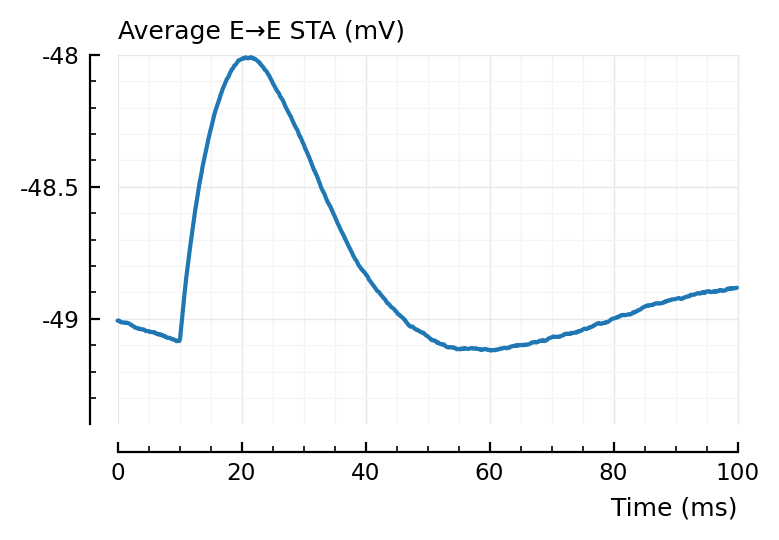

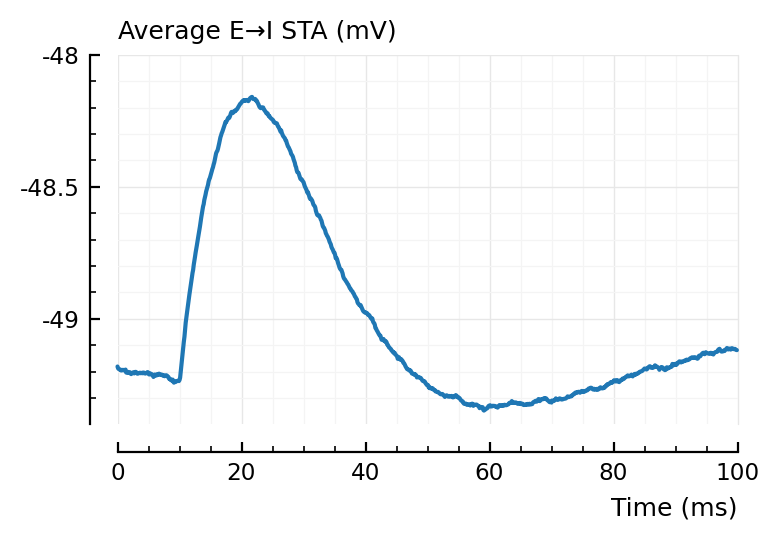

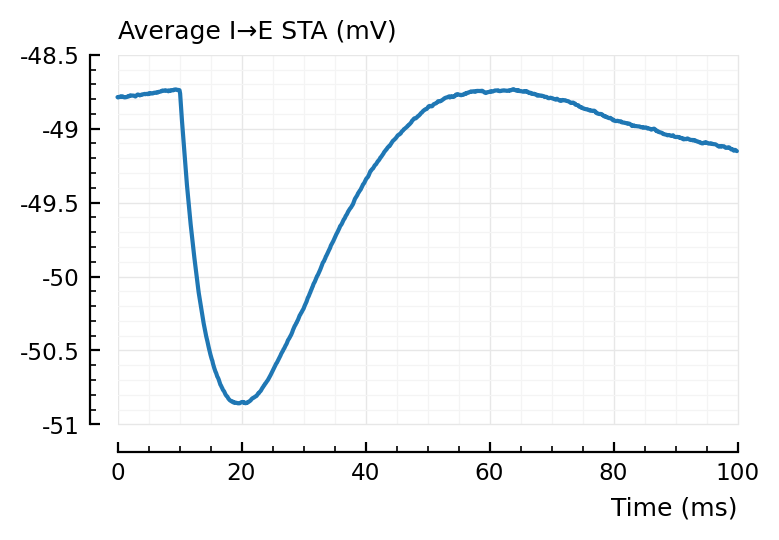

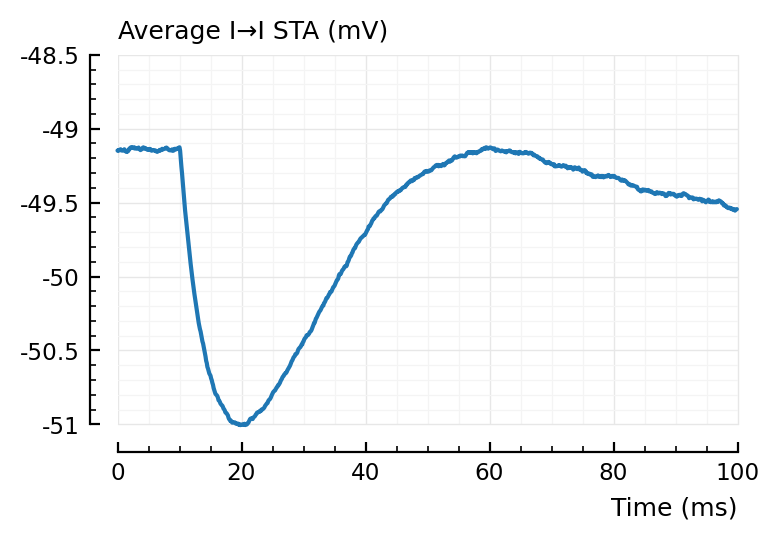

In [123]:
plotsig(avgSTA_EE / mV, p, hylabel="Average E→E STA (mV)", ylim=[-49.4, -48]); plt.subplots();
plotsig(avgSTA_EI / mV, p, hylabel="Average E→I STA (mV)", ylim=[-49.4, -48]); plt.subplots();
plotsig(avgSTA_IE / mV, p, hylabel="Average I→E STA (mV)", ylim=[-51, -48.5]); plt.subplots();
plotsig(avgSTA_II / mV, p, hylabel="Average I→I STA (mV)", ylim=[-51, -48.5]);

Inhibitory neurons seem to have a lower average voltage, from looking at their STA baselines.

In [140]:
avg_voltage(group) = mean([mean(s.signals[n].v) for n in group])

avg_voltage(exc_post) / mV

-49

In [137]:
avg_voltage(inh_post) / mV

-49.2

Yup, that tracks.

## Disynaptic false positive (FP) hypothesis

We suspect false positive detections are due to an intermediary connected neuron.

A → B → C

A fires, makes B fire¹, which generates a PSP in the recorded neuron C.

But this PSP happens with a larger delay after the A spike than if A would be directly connected to C.

So let's test if the peak of the STA of unconnected-but-detected (i.e. FP) neurons occurs later than the peak of non-detected unconnected neurons (the timing of which should be random).


¹(sometimes at least)

In [154]:
tn = perf.tested_neurons;
# We'll add columns: for every neuron (tp exc, tp inh, fp, tn),
# we'll calc when the peak occurs (max or min, depending on area-over-start) and add that.

In [181]:
m = 1;

In [205]:
peak_over_start = Float64[]
peakpos_ms = Float64[]
for row in eachrow(tn)
    STA = calcSTA(row.input_neuron_ID, m, s,p)
    f = (row.area_over_start > 0) ? findmax : findmin
    peak, peakpos = f(STA)
    push!(peak_over_start, (peak - STA[1]) / mV)
    push!(peakpos_ms, peakpos * p.sim.general.Δt / ms)
end
tn.peak_over_start = peak_over_start
tn.peakpos_ms = peakpos_ms;

In [219]:
ENV["COLUMNS"] = 100;  # show all columns of df

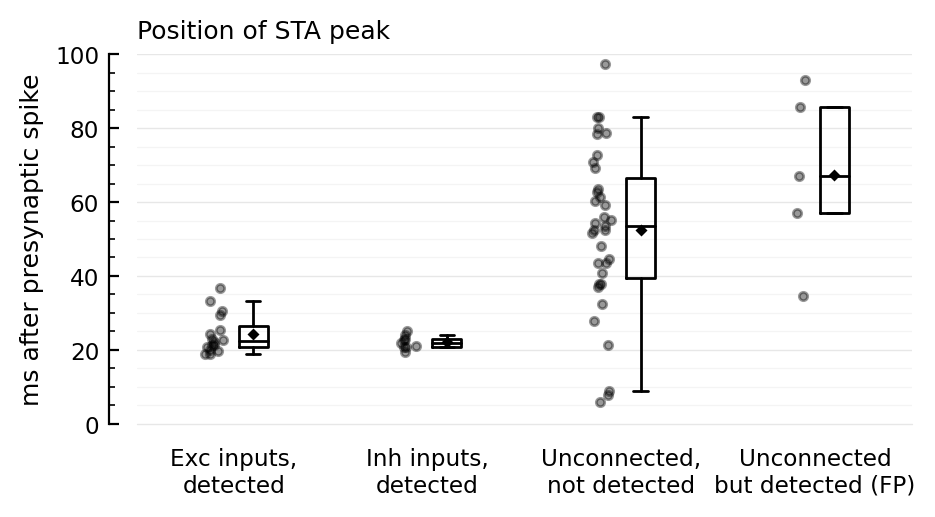

In [225]:
ydistplot(
    jn("Exc inputs,", "detected")          => tn.peakpos_ms[(tn.real_type .== :exc) .& (tn.predicted_type .== :exc)],
    jn("Inh inputs,", "detected")          => tn.peakpos_ms[(tn.real_type .== :inh) .& (tn.predicted_type .== :inh)],
    jn("Unconnected,", "not detected")     => tn.peakpos_ms[(tn.real_type .== :unconn) .& (tn.predicted_type .== :unconn)],
    jn("Unconnected", "but detected (FP)") => tn.peakpos_ms[(tn.real_type .== :unconn) .& (tn.predicted_type .!= :unconn)],
    figsize = (5, 2.4),
    hylabel = "Position of STA peak", 
    ylabel = "ms after presynaptic spike",
);